# 02. Generate loop censuses, Denmark-wide
## Project: Bicycle node network loop analysis

This notebook generates a loop census for each node from the preprocessed and snapped Denmark-wide network from 01, and calculates/plots basic descriptive statistics for the whole country of Denmark.  
Please select `denmark` as the `study_area` in the `config.yml`.

Contact: Michael Szell (michael.szell@gmail.com)

Created: 2024-01-24  
Last modified: 2025-09-10

## To do

- [ ] Double-check loop/link lengths. For example 3-loop east of Faxe
- [ ] Double-check edge_ids during simplifications
- [ ] Semilogy scale for loop lengths

## Parameters

In [1]:
%run -i setup_parameters.py
debug = True  # Set to True for extra plots and verbosity

## Functions

In [2]:
%run -i functions.py

## Load data

In [3]:
Gnx = nx.empty_graph()
with lzma.open(PATH["data_out"] + "network_preprocessed.xz", "rb") as f:
    G_new = pickle.load(f)
    Gnx = nx.disjoint_union(Gnx, G_new.to_networkx())
if debug:
    print("N: " + str(Gnx.number_of_nodes()), ", L: " + str(Gnx.number_of_edges()))
    for k, v in list(Gnx.nodes(data=True))[:10]:
        print(k, v)
    for u, v in Gnx.edges(list(range(3))):
        print(u, v)

N: 59 , L: 89
0 {'x': 664790.17621861, 'y': 6231667.991771109, 'name': 0, '_igraph_index': 0}
1 {'x': 668758.8, 'y': 6232075.839999998, 'name': 1, '_igraph_index': 1}
2 {'x': 661658.9299999999, 'y': 6234106.799999998, 'name': 2, '_igraph_index': 2}
3 {'x': 665859.66, 'y': 6234266.65, 'name': 3, '_igraph_index': 3}
4 {'x': 666896.12, 'y': 6234528.369999999, 'name': 4, '_igraph_index': 4}
5 {'x': 671555.2800000003, 'y': 6239109.709999998, 'name': 5, '_igraph_index': 5}
6 {'x': 661676.94, 'y': 6234126.139999998, 'name': 6, '_igraph_index': 6}
7 {'x': 658541.2699999997, 'y': 6234478.759999998, 'name': 7, '_igraph_index': 7}
8 {'x': 663870.8599999999, 'y': 6235105.269999997, 'name': 8, '_igraph_index': 8}
9 {'x': 667180.6099999999, 'y': 6236397.849999999, 'name': 9, '_igraph_index': 9}
0 1
0 2
0 3
1 4
1 5
2 6
2 7


In [4]:
# just dummy files that must be saved due to copy paste from old code. eventually fix and remove.
nodes_id = list()
nodes_coords = list()

## Loop generation

### Get face loops

The minimum cycle basis is generally not the cycle basis of face loops, see: https://en.wikipedia.org/wiki/Cycle_basis#In_planar_graphs  
Therefore, we can't use https://python.igraph.org/en/latest/api/igraph.GraphBase.html#minimum_cycle_basis here. Instead, we solve the problem geometrically via shapely.

#### Polygonize

[<LINESTRING (664790.176 6231667.992, 664809.13 6231671.23, 664830.26 6231674...>, <LINESTRING (661658.93 6234106.8, 661668.7 6234101.93, 661683.216 6234094.96...>, <LINESTRING (664790.176 6231667.992, 664790.75 6231674.42, 664790.024 623168...>, <LINESTRING (666896.12 6234528.37, 666899.6 6234512.98, 666912.24 6234478.04...>, <LINESTRING (668758.8 6232075.84, 668772.57 6232084.84, 668794.44 6232099, 6...>, <LINESTRING (661676.94 6234126.14, 661674.1 6234123.79, 661665.651 6234114.4...>, <LINESTRING (658541.27 6234478.76, 658557.74 6234469.47, 658576.97 6234458.3...>, <LINESTRING (665859.66 6234266.65, 665858.83 6234278.08, 665858.4 6234295.13...>, <LINESTRING (663870.86 6235105.27, 663873.49 6235101.98, 663901.25 6235067.8...>, <LINESTRING (666896.12 6234528.37, 666902.63 6234528.5, 666974.9 6234533.75,...>]


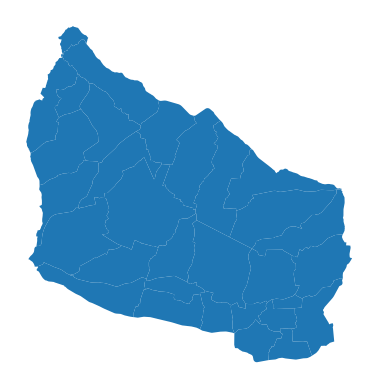

In [5]:
edgegeoms = list(nx.get_edge_attributes(Gnx, "geometry").values())
facepolygons, _, _, _ = shapely.polygonize_full(edgegeoms)
if debug:
    print(edgegeoms[:10])
    p = gpd.GeoSeries(facepolygons)
    p.plot()
    plt.axis("off")

#### Intersect polygons with graph to get face loops

In [6]:
# Code from: https://github.com/anastassiavybornova/bike-node-planner/blob/main/scripts/script06.py
ns, es = momepy.nx_to_gdf(net=Gnx, points=True, lines=True)

linestrings = (
    es.geometry.copy()
)  # our geopandas.GeoSeries of linestrings representing street network
collection = shapely.GeometryCollection(linestrings.array)  # combine to a single object
noded = shapely.node(collection)  # add missing nodes
polygonized = shapely.polygonize(
    noded.geoms
)  # polygonize based on an array of nodded parts
polygons = gpd.GeoSeries(polygonized.geoms)  # create a GeoSeries from parts

# create geodataframe of loops, where we will save evaluation column
faceloops = gpd.GeoDataFrame(geometry=polygons, crs=es.crs)
if debug:
    print(faceloops.head(5))

                                            geometry
0  POLYGON ((668758.8 6232075.84, 668745.52 62320...
1  POLYGON ((664790.176 6231667.992, 664779.63 62...
2  POLYGON ((668758.8 6232075.84, 668757.862 6232...
3  POLYGON ((661676.94 6234126.14, 661674.1 62341...
4  POLYGON ((666896.12 6234528.37, 666865.84 6234...


/var/folders/q4/95x26cls17s1z694v56lw3hh0000gn/T/ipykernel_56792/609980743.py:2: UserWarning: Approach is not set. Defaulting to 'primal'.
  ns, es = momepy.nx_to_gdf(net=Gnx, points=True, lines=True)


In [7]:
faceloopnodes = []
for fl in faceloops.itertuples():  # loop through each face loop fl
    nsinters = ns.intersection(
        fl.geometry
    )  # intersect all nodes with the fl's geometry
    nsinters = nsinters[~nsinters.is_empty]  # remove empties
    faceloopnodes.append(len(nsinters))  # save number of nodes

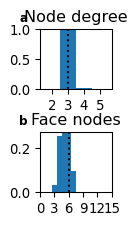

In [8]:
fig = plt.figure(
    figsize=(110 / PLOTPARAM["dpi"], 200 / PLOTPARAM["dpi"]), dpi=PLOTPARAM["dpi"]
)
axes2 = fig.add_axes([0.2, 0.59, 0.65, 0.3])
axes1 = fig.add_axes([0.2, 0.075, 0.65, 0.3])

axes2.hist(
    [val for (node, val) in Gnx.degree()], density=True, bins=[2, 3, 4, 5], align="left"
)
axes2.set_title("Node degree")
axes2.set_xticks([2, 3, 4, 5])
axes2.set_xlim([1.25, 5.75])
axes2.set_ylim([0, 1])
axes2.plot([3, 3], [0, 1], "k:")
axes2.text(-0.29, 1.13, "a", transform=axes2.transAxes, weight="bold", size=9)

axes1.hist(faceloopnodes, range(16), density=True, align="left")
axes1.set_title("Face nodes")
axes1.set_xticks([0, 3, 6, 9, 12, 15])
axes1.set_xlim([0, 15])
axes1.set_ylim([0, 0.275])
axes1.plot([6, 6], [0, 1], "k:")
axes1.text(-0.29, 1.13, "b", transform=axes1.transAxes, weight="bold", size=9)

# plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
fig.savefig(PATH["plot"] + "degreefacenodes" + "." + PLOTPARAM["format"]);

~~Getting all simple loops has not yet been implemented in igraph, see:  
* https://github.com/igraph/igraph/issues/379  
* https://github.com/igraph/igraph/issues/1398  
Some potential progress here, but only for C, not Python:
* https://github.com/igraph/igraph/pull/2181

But they can be XORed through the loop base.~~

Update 2025-06-19: It *has* been implemented now! 🎉  
https://github.com/igraph/python-igraph/releases/tag/0.11.9  
https://python.igraph.org/en/0.11.9/api/igraph.GraphBase.html#simple_cycles  

It has been implemented in networkX though: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.simple_cycles.html#networkx.algorithms.cycles.simple_cycles

Therefore, we do not use igraph's loop basis, but go ahead with networkX.

### Get all loops via igraph

to do

### Get all loops via nx

Can take hours:

In [9]:
# Get all loops, meaning a loop ABCA is counted also as BCAB and CABC
allloops, alllooplengths, allloopnumnodes, allloopmaxslopes = get_allloops_nx(Gnx)

Generate all loops: 0it [00:00, ?it/s]

Found 1815 loops for number of nodes bound 30 and length bound 40000m


Extract global loop properties:   0%|          | 0/59 [00:00<?, ?it/s]

Turn loop data into numpy arrays:   0%|          | 0/59 [00:00<?, ?it/s]

## Save loop census

In [10]:
if LOOP_LENGTH_BOUND:
    llb_string = "_maxlength" + str(LOOP_LENGTH_BOUND)
else:
    llb_string = ""

with open(
    PATH["data_out"] + "loopcensus_" + str(LOOP_NUMNODE_BOUND) + llb_string + ".pkl",
    "wb",
) as f:
    pickle.dump(allloops, f)
    pickle.dump(alllooplengths, f)
    pickle.dump(allloopnumnodes, f)
    pickle.dump(allloopmaxslopes, f)
    pickle.dump(Gnx, f)
    pickle.dump(LOOP_NUMNODE_BOUND, f)
    pickle.dump(nodes_id, f)
    pickle.dump(nodes_coords, f)
    #pickle.dump(numloops, f)
    pickle.dump(faceloops, f)